In [1]:
import redmagic
from matplotlib import pyplot as plt
import glob
import os
import time
import numpy as np
import ezgal
import pickle
import matplotlib.colors as clr
from redmagic.utils import CubicSpline,make_nodes
from redmagic.fitters import MedZFitter,RedSequenceFitter
from tqdm import tqdm
import redmapper
import scipy
import ezgal
import esutil
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [9]:
class Object(object):
    pass
file = open('redmagic/data/seed_gals_v2_0.pkl', 'rb')
gals = pickle.load(file)
file.close()
print(gals.__dict__.keys())

dict_keys(['z', 'galcol', 'refmag', 'p', 'mag_err'])


In [10]:
model = ezgal.model( 'bc03_ssp_z_0.02_salp.model')
model.set_ab_output()
model.set_normalization( 'sloan_i', 0.2, 17.85,apparent=True)

def m_star (redshift):
    m_c = model.get_apparent_mags( zf = 4., filters='Roman_F', zs=redshift)
    return(m_c)

/root/anaconda3/envs/Redmagic/lib/python3.10/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


In [11]:
# Getting Red-sequence tempalte parameters ready

zrange = [1.3,1.9]
zbinsize = 0.001
nz = np.round((zrange[1]-zrange[0])/zbinsize).astype('i4')
z = zbinsize*np.arange(nz) + zrange[0]
z = np.append(z,z[z.size-1])

nz += 1


file = open('redmagic/data/pars_v2_0.pkl', 'rb')
pars = pickle.load(file)
file.close()

ztag = [None] * 2
ctag = [None] * 2
zstag = [None] * 2
stag = [None] * 2
for j in range(2):
    ztag[j] = 'z%02d' % (j)
    ctag[j] = 'c%02d' % (j)
    zstag[j] = 'zs%02d' % (j)
    stag[j] = 'slope%02d' % (j)
    


ncol = 2
# Volume factor
spl=CubicSpline(pars.volume_factor_z,pars.volume_factor)
volume_factor = spl(z)

pivotmag = np.zeros(z.size, dtype=np.float64)
spl=CubicSpline(pars.pivotmag_z, pars.pivotmag)
pivotmag[:] = spl(z)

# Mean color
c = np.zeros((nz,ncol),dtype=np.float64)
# Slope
slope = np.zeros((nz,ncol),dtype=np.float64)
for j in range(ncol):

    spl=CubicSpline(pars._ndarray[ztag[j]],pars._ndarray[ctag[j]])
    c[:,j] = spl(z)
    
    spl=CubicSpline(pars._ndarray[zstag[j]],pars._ndarray[stag[j]])
    slope[:,j] = spl(z)
    
# Diagonal components of covariance matrix
sigma = np.zeros((ncol,ncol,nz),dtype=np.float64)
covmat = np.zeros((ncol,ncol,nz),dtype=np.float64)
minsig = 0.01
for j in range(ncol):
    spl=CubicSpline(pars.covmat_z,pars.sigma[j,j,:])
    sigma[j,j,:] = np.clip(spl(z), minsig, None)
    covmat[j,j,:] = sigma[j,j,:]*sigma[j,j,:]
    
# off-diagonals
for j in range(ncol):
    for k in range(j+1,ncol):
        
        sigma[j,k,:] = 0.9
        sigma[k,j,:] = sigma[j,k,:]

        covmat[j,k,:] = sigma[k,j,:] * sigma[j,j,:] * sigma[k,k,:]
        covmat[k,j,:] = covmat[j,k,:]

In [12]:
zbinscale=int(1./zbinsize)

zinteger=np.round(z*zbinscale).astype(np.int64)

zinds = np.searchsorted(zinteger,np.round(np.atleast_1d(z)*zbinscale).astype(np.int64))

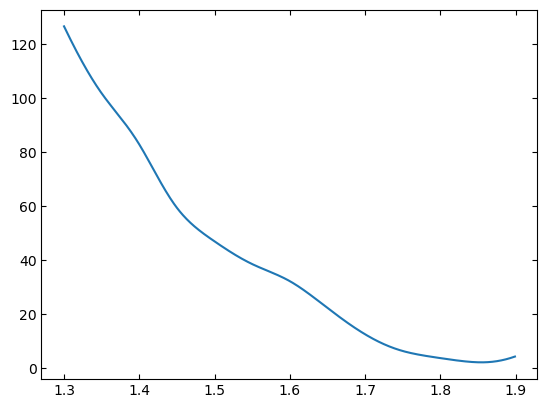

In [16]:
gal_idx = 22
galcolor = gals.galcol[gal_idx][:2]
mag_err = gals.mag_err[gal_idx][:3].copy()
chisq = redmapper.chisq_dist.compute_chisq(covmat=covmat[:,:,zinds],c=c[zinds,:],slope=slope[zinds,:],pivotmag=pivotmag[zinds],
                                   refmag=gals.refmag[gal_idx],magerr= mag_err,color=galcolor)

lndist = -0.5*chisq

alpha = 1
lndistcorr = np.log((10.**(0.4 * (alpha + 1.0) *
                            (m_star(z[zinds]) - gals.refmag[gal_idx])) *
                        np.exp(-10.**(0.4 * (m_star(z[zinds]) - gals.refmag[gal_idx])))) *
                    volume_factor[zinds])
lndist += lndistcorr

bad, = np.where(~np.isfinite(lndist))
lndist[bad] = -1e11

plt.plot(z[zinds],chisq)

In [17]:
maxlndist = np.max(lndist)
dist = np.zeros_like(lndist)
with np.errstate(invalid='ignore', over='ignore'):
    dist = np.exp(lndist - maxlndist)
bad, = np.where(~np.isfinite(dist))
dist[bad] = 0.0


calcinds, = np.where(dist > 1e-5)
tdist = scipy.integrate.trapz(dist[calcinds], z[calcinds])
zred_temp = scipy.integrate.trapz(dist[calcinds] * z[calcinds],
                                    z[calcinds]) / tdist
zred_e = scipy.integrate.trapz(dist[calcinds] * z[calcinds]**2.,
                            z[calcinds]) / tdist - zred_temp**2.

zred_temp,np.sqrt(zred_e)

(1.8372919983063016, 0.037612890281990184)

In [18]:
z_red = []
z_red_e = []
for i in tqdm(range(len(gals.z))):
    gal_idx = i
    galcolor = gals.galcol[gal_idx][:2]
    mag_err = gals.mag_err[gal_idx][:3].copy()
    chisq = redmapper.chisq_dist.compute_chisq(covmat=covmat[:,:,zinds],c=c[zinds,:],slope=slope[zinds,:],pivotmag=pivotmag[zinds],
                                    refmag=gals.refmag[gal_idx],magerr= mag_err,color=galcolor)

    lndist = -0.5*chisq

    alpha = 1
    lndistcorr = np.log((10.**(0.4 * (alpha + 1.0) *
                                (m_star(z[zinds]) - gals.refmag[gal_idx])) *
                            np.exp(-10.**(0.4 * (m_star(z[zinds]) - gals.refmag[gal_idx])))) *
                        volume_factor[zinds])
    lndist += lndistcorr

    bad, = np.where(~np.isfinite(lndist))
    lndist[bad] = -1e11


    maxlndist = np.max(lndist)
    dist = np.zeros_like(lndist)
    with np.errstate(invalid='ignore', over='ignore'):
        dist = np.exp(lndist - maxlndist)
    bad, = np.where(~np.isfinite(dist))
    dist[bad] = 0.0


    calcinds, = np.where(dist > 1e-5)
    tdist = scipy.integrate.trapz(dist[calcinds], z[calcinds])
    zred_temp = scipy.integrate.trapz(dist[calcinds] * z[calcinds],
                                        z[calcinds]) / tdist
    zred_e = scipy.integrate.trapz(dist[calcinds] * z[calcinds]**2.,
                                z[calcinds]) / tdist - zred_temp**2.

    z_red.append(zred_temp)
    z_red_e.append(np.sqrt(zred_e))

100%|██████████| 8609/8609 [16:13<00:00,  8.84it/s]


In [26]:
len(mask)

1088

In [27]:
np.save('redmagic/data/z_red_redmapper',np.array(z_red))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


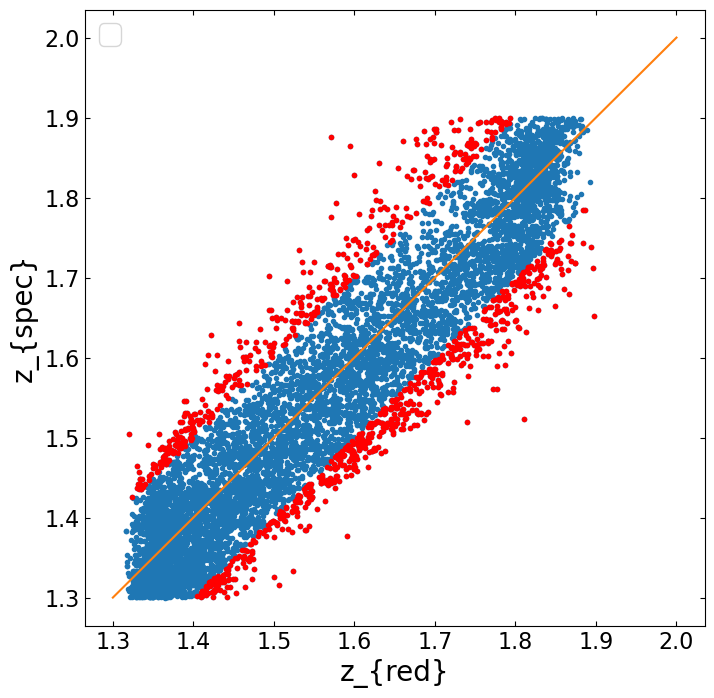

In [25]:
plt.figure(figsize = (8,8))
plt.plot(z_red,gals.z,'.')
mask, =np.where(np.abs(np.array(z_red)-gals.z) > 0.1)
plt.plot(np.array(z_red)[mask],gals.z[mask],'.',color= 'red')
xx = np.linspace(1.3,2.)
plt.plot(xx,xx,'-')
plt.xlabel(r'z_{red}', fontsize = 20)
plt.ylabel(r'z_{spec}',fontsize = 20)
plt.xticks(fontsize = 16);
plt.yticks(fontsize = 16);
plt.legend(fontsize = 20)